# Установка нужных библиотек

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# try:
#     import google.colab
#     IN_COLAB = True
# except:
#     IN_COLAB = False

# if IN_COLAB:
#     !git clone -qq https://github.com/Intelligent-Systems-Phystech/ProjectTemplate.git /tmp/repo
#     !python3 -m pip install -qq /tmp/repo/src/ && rm -rf /tmp/repo

# Импорт библиотек

In [ ]:
from sklearn.datasets import make_moons, make_circles

import torch
from torch import nn
from torch import optim
from torch.distributions import MultivariateNormal, Normal

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [ ]:
N_SAMPLES = 1_500

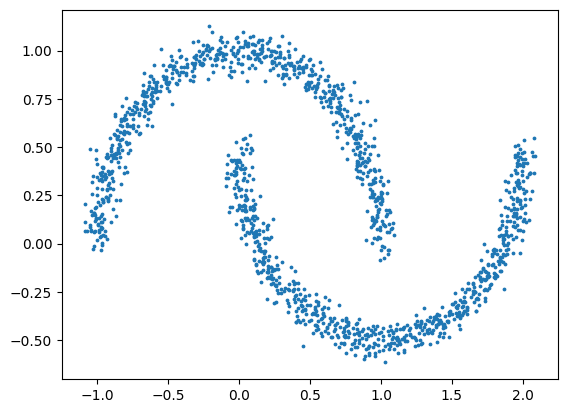

torch.float32

In [ ]:
moons = torch.tensor(make_moons(N_SAMPLES, noise=0.05)[0], dtype=torch.float32)
plt.scatter(moons[:, 0], moons[:, 1], s=3)
plt.show()
moons.shape
moons = moons.to('cuda')
moons.dtype

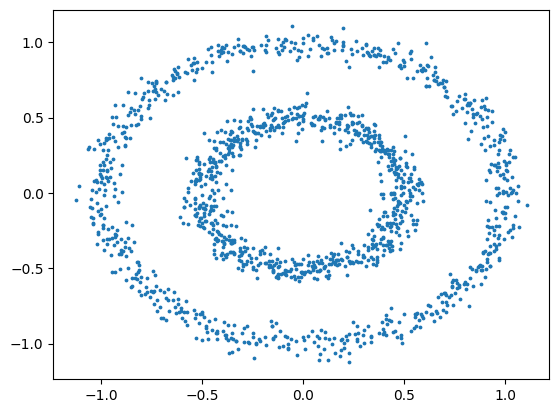

(1500, 2)

In [ ]:
circles = make_circles(N_SAMPLES, noise=0.05, factor=0.5)[0]
plt.scatter(circles[:, 0], circles[:, 1], s=3)
plt.show()
circles.shape

In [ ]:
normal = MultivariateNormal(torch.zeros(2).to('cuda'), torch.eye(2).to('cuda'))
norm_samples = normal.sample([N_SAMPLES])
# plt.scatter(norm_samples[:, 0], norm_samples[:, 1], s=3)
# plt.show()

norm_samples.dtype

torch.float32

In [ ]:
normal_1 = Normal(5, 1)
norm_1 = normal_1.sample([N_SAMPLES])

normal_2 = Normal(-2, 2)
norm_2 = normal_2.sample([N_SAMPLES])

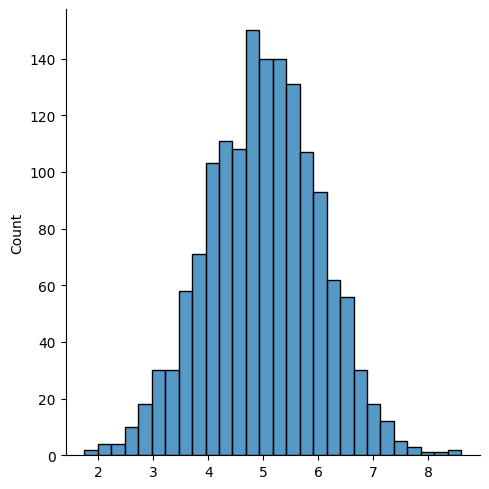

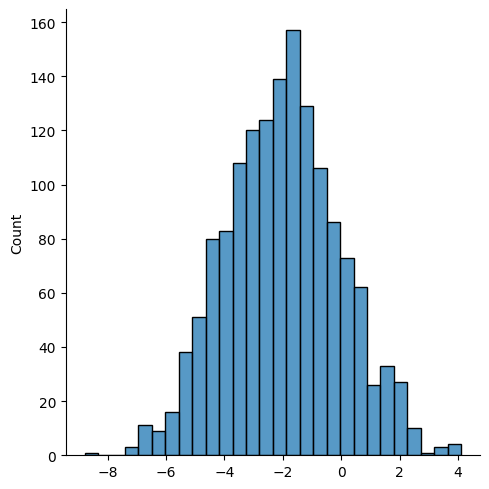

In [ ]:
sns.displot(norm_1)
sns.displot(norm_2)

norm_1 = norm_1.to('cuda')
norm_2 = norm_2.to('cuda')

## Algorithm
Заданной динамикой построить другую которая будет ограничена
Let we have dataset $\{y_j\}_{j=1}^m \forall y_j\in\mathbb{R}^2$ and we have latent distribution $\pi_0(x) = \mathcal{N}(0, I_2)$

$$
  \beta^* = \arg\max_\beta\frac1n\sum_{i=1}^n\log(\phi_1(y_i, \beta)) - \frac1{\tilde n \tilde m}\sum_{i}^{\tilde n}\sum_{j}^{\tilde m}\phi_1(\tilde y_j^i, \beta)\frac{\hat\phi_0(\tilde x_i, \alpha)}{\tilde\pi_0(\tilde x_i)},
$$
where $\tilde\pi_0(x)$ - some kind of KDE of dataset,<br>
$\tilde x_i \sim \pi_0(x)$ $\forall i\in\overline{1,\tilde n}$, <br>
$\tilde y_j^i \sim p(y|\tilde x_i)$ $\forall i\in\overline{1,\tilde n}$ $\forall j\in\overline{1,\tilde m}$, <br>
$n$ - number of smaples from $\pi_0(x)$

$$
  \alpha^* = \arg\max_\alpha\frac1m\sum_{j=1}^m\log(\hat\phi_0(x_j, \alpha)) - \frac1{\tilde n \tilde m}\sum_{i}^{\tilde n}\sum_{j}^{\tilde m}\phi_1(\tilde y_j^i, \beta)\frac{\hat\phi_0(\tilde x_i, \alpha)}{\tilde\pi_0(\tilde x_i)},
$$
where $\tilde\pi_0(x)$ - some kind of KDE of dataset,<br>
$\tilde x_i \sim \pi_0(x)$ $\forall i\in\overline{1,\tilde n}$, <br>
$\tilde y_j^i \sim p(y|\tilde x_i)$ $\forall i\in\overline{1,\tilde n}$ $\forall j\in\overline{1,\tilde m}$, <br>
$n$ - number of smaples from $\pi_0(x)$<br>

Now we have two functions $\phi_1(y, \beta^*), \hat\phi_0(x, \alpha^*)$ which can be used to calculate joint distribution $q^*(x, y)$<r>

To generata data $y$ we use
<!-- q(y|x) = \frac{q^*(x, y)}{\pi_0(x)} = \frac{\phi_1(y, \beta^*) p(y|x) \hat\phi_0(x, \alpha^*)}{\pi_0(x)}  -->
$$
\pi^*_1(y) = \phi_1(y_j, \beta^*)\hat\phi_1(y)
$$
<br>
$$
q(y|x) = \frac{q^*(x, y)}{\pi_0(x)} = \frac{\phi_1(y, \beta^*) p(y|x) \hat\phi_0(x, \alpha^*)}{\pi_0(x)}
$$



## Model
We will parametrize $\phi_1(y, \beta), \hat\phi_0(x, \alpha)$ with One-Layer NN with ReLU activation and 64 output size.

In [ ]:
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(1, 32),
      nn.ReLU(),
      nn.Linear(32, 1),
      nn.Softplus()
    )

  def forward(self, x):
    x = x[:, None]
    return self.layers(x)

In [ ]:
EPOCHS = 250
INNER_STEP = 150

phi_0 = MLP()
phi_1 = MLP()

phi_0.to('cuda')
phi_1.to('cuda')

# Prior conditional  distribution p(y|x_s) = Normal(y | x_s, gamma*I)
# for sample in norm_samples:
gamma = 1000
y_x = Normal(norm_1, gamma * 1).sample([400]).to('cuda')

optimizer_forward = optim.Adam(phi_0.parameters(), lr=0.001)
optimizer_backward = optim.Adam(phi_1.parameters(), lr=0.001)

In [ ]:
losses = {
    'forward': [],
    'backward': []
}

samples_probs = normal_1.log_prob(norm_1).exp()[:, None]

for i in tqdm(range(EPOCHS)):
    temp_loss = 0
    for j in range(INNER_STEP):
        optimizer_forward.zero_grad()
        output = phi_0(norm_1)
        model_log = output.log().mean(dim=0)
        constraint = (phi_1(y_x.reshape(-1, 1)).reshape(400, -1, 1).mean(dim=0) * output / samples_probs).mean(dim=0)

        loss_forward =  -(model_log - constraint).mean()
        temp_loss += loss_forward.cpu().detach().numpy()
        loss_forward.backward()
        optimizer_forward.step()
    losses['forward'].append(temp_loss/INNER_STEP)

    temp_loss = 0
    for j in range(INNER_STEP):
        optimizer_backward.zero_grad()
        model_log = phi_1(norm_2).log().mean(dim=0)
        constraint = (phi_1(y_x.reshape(-1, 1)).reshape(400, -1, 1).mean(dim=0) * phi_0(norm_1) / samples_probs).mean(dim=0)

        loss_backward = -(model_log - constraint).mean()
        temp_loss += loss_forward.cpu().detach().numpy()
        loss_backward.backward()
        optimizer_backward.step()
    losses['backward'].append(temp_loss/INNER_STEP)


100%|██████████| 250/250 [06:17<00:00,  1.51s/it]


In [ ]:
losses

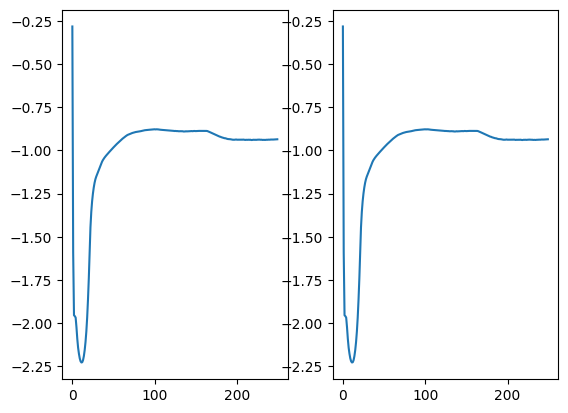

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(losses['forward'])
ax[1].plot(losses['forward'])

plt.show()

In [ ]:
phi_0.cpu()
phi_1.cpu()

MLP(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
    (3): Softplus(beta=1, threshold=20)
  )
)

In [ ]:
phi_1(normal_1.sample([400])).mean(0)[:, None].shape

torch.Size([1, 1])

In [ ]:
test_samples_1 = normal_1.sample([1000])
test_samples_2 = normal_2.sample([1000])

test_probs = (phi_0(test_samples_1) * phi_1(test_samples_2)).detach().numpy().squeeze()


(torch.Size([1000]), (1000,))

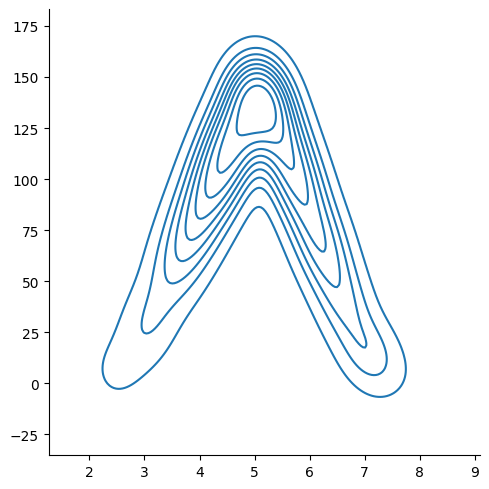

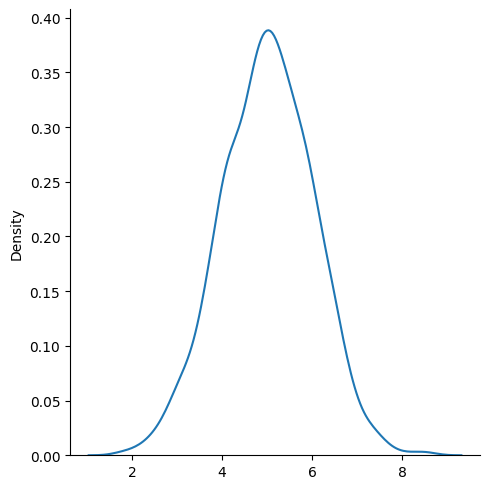

In [ ]:
sns.displot(x=test_samples, y=test_probs, kind='kde')
sns.displot(norm_1.cpu(), kind='kde')

## New experiments

In [652]:
!pip install numpy matplotlib scipy scikit-learn seaborn pandas tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 4.9 MB/s eta 0:00:00


In [732]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import numpy as np
from scipy.stats import norm

from tqdm.notebook import tqdm

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_moons, make_circles

In [666]:
def visualize_GAN(gan, real_data):
    num = 500
    real_data = pd.DataFrame(real_data, columns=['x', 'y'])
    samples = pd.DataFrame(gan.sample(num), columns=['x', 'y'])
    
    fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
    sns.kdeplot(real_data, x='x', y='y', fill=True, ax=axs[0])
    sns.kdeplot(samples, x='x', y='y', fill=True, color='r', ax=axs[1])
    plt.show()

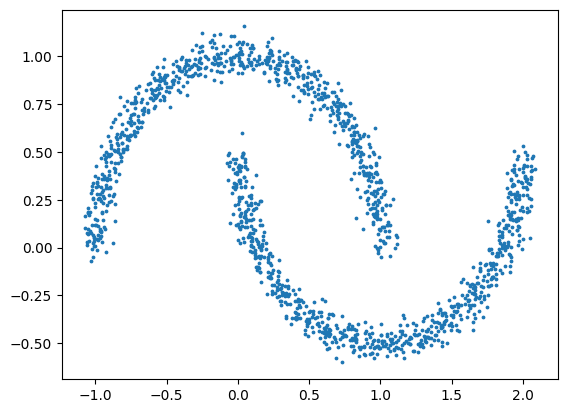

In [667]:
moons = torch.tensor(make_moons(1500, noise=0.05)[0], dtype=torch.float32)
plt.scatter(moons[:, 0], moons[:, 1], s=3)
plt.show()

In [805]:
class GAN():
    def __init__(self, n_latent=2, device='cpu'):
        self.gen = self._get_simple_model([n_latent, 32, 32, 32, 2]).to(device)
        self.disc = nn.Sequential(*self._get_simple_model([2, 32, 32, 32, 1], True), nn.Sigmoid()).to(device)
        self.noise_fn = lambda num: torch.normal(0, 1, size=(num, self.n_latent), device=device)

        self.n_latent = n_latent
        self.device = device
        
    def sample(self, num=1000):
        latent_vec = self.noise_fn(num)
        with torch.no_grad():
            samples = self.gen(latent_vec)
        return samples.cpu().numpy()

    def _get_simple_model(self, hiddens, disc=False):
        assert len(hiddens) > 1
        activation = nn.LeakyReLU() if disc else nn.ReLU()
        modules = []
        for in_, out_ in zip(hiddens[:-2], hiddens[1:-1]):
            modules.extend([nn.Linear(in_, out_),nn.BatchNorm1d(out_), nn.ReLU()])
        modules.append(nn.Linear(hiddens[-2], hiddens[-1]))
        return nn.Sequential(*modules)

In [810]:
class GANTrainer():
    def __init__(self, model, batch_size=32, lr_disc=1e-3, lr_gen=2e-4):
        self.model = model
        self.batch_size = batch_size
        self.device = model.device
        self.criterion = nn.BCELoss()
        self.optim_disc = torch.optim.Adam(model.disc.parameters(), lr=lr_disc)
        self.optim_gen = torch.optim.Adam(model.gen.parameters(), lr=lr_gen)

    def _train_step_gen(self):
        """Train the generator one step and return the loss."""
        self.model.gen.zero_grad()
        
        latent_vec = self.model.noise_fn(self.batch_size)
        generated = self.model.gen(latent_vec)
        classifications = self.model.disc(generated)
        loss = self.criterion(classifications, torch.ones((self.batch_size, 1)).to(self.device))
        
        loss.backward()
        self.optim_gen.step()
        return loss.item()

    def _train_step_disc(self, real_data):
        """Train the discriminator one step and return the losses."""
        self.model.disc.zero_grad()

        pred_real = self.model.disc(real_data)
        loss_real = self.criterion(pred_real, torch.ones((self.batch_size, 1)).to(self.device))

        latent_vec = self.model.noise_fn(self.batch_size)
        with torch.no_grad():
            fake_samples = self.model.gen(latent_vec)
        pred_fake = self.model.disc(fake_samples)
        loss_fake = self.criterion(pred_fake, torch.zeros((self.batch_size, 1)).to(self.device))

        loss = (loss_real + loss_fake) / 2
        loss.backward()
        self.optim_disc.step()
        
        return loss_real.item(), loss_fake.item()

    def _train_step(self, real_data):
        """Train both networks and return the losses."""
        loss_disc = self._train_step_disc(real_data)
        loss_gen = self._train_step_gen()
        return loss_gen, loss_disc

    def train(self, epochs, dataloader):
        losses = {'loss_gen': [], 'loss_disc_real': [], 'loss_disc_fake': []}
        for epoch in tqdm(range(epochs)):
            avg_loss_gen = 0
            avg_loss_disc_real = 0
            avg_loss_disc_fake = 0
            # for batch in tqdm(dataloader):
            for batch in dataloader:
                self.batch_size = batch.shape[0]
                loss_gen, (loss_disc_real, loss_disc_fake) = self._train_step(batch.to(self.device))
                avg_loss_gen += loss_gen
                avg_loss_disc_real += loss_disc_real
                avg_loss_disc_fake += loss_disc_fake
            losses['loss_gen'].append(avg_loss_gen / len(dataloader))
            losses['loss_disc_real'].append(avg_loss_disc_real / len(dataloader))
            losses['loss_disc_fake'].append(avg_loss_disc_fake / len(dataloader))
            # print(f'gen Loss: {losses["loss_gen"][-1]}, disc Real Loss: {losses["loss_disc_real"][-1]}, disc Fake Loss: {losses["loss_disc_fake"][-1]}')
            # visualize_GAN(self.model, moons)
        return losses

In [811]:
BATCH_SIZE = 32
EPOCHS = 200
LR_D = 1e-4
LR_G = 3e-5
N_LATENS = 2

dataloader = DataLoader(moons, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

gan = GAN(N_LATENS, device='cuda')

trainer = GANTrainer(gan, batch_size=BATCH_SIZE, lr_disc=LR_D, lr_gen=LR_G)
losses = trainer.train(EPOCHS, dataloader)

  0%|          | 0/200 [00:00<?, ?it/s]

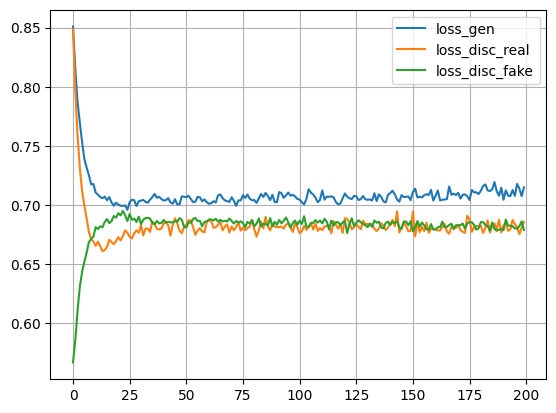

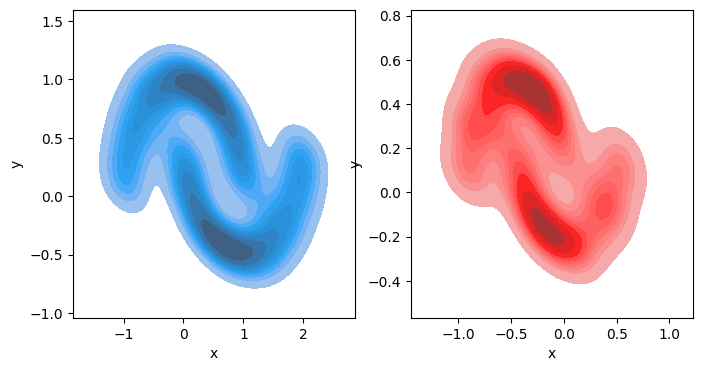

In [812]:
plt.figure()
for key, value in losses.items():
    plt.plot(range(len(value)), value, label=key)
plt.grid()
plt.legend()
plt.show()
visualize_GAN(gan, moons)

## CycleGAN

In [813]:
def visualize_CycleGAN(gan_x, gan_y, x, y):
    num = 500
    fake_x = pd.DataFrame(gan_x.gen(y.cuda()).cpu().detach().numpy(), columns=['x', 'y'])
    fake_y = pd.DataFrame(gan_y.gen(x.cuda()).cpu().detach().numpy(), columns=['x', 'y'])
    x = pd.DataFrame(x, columns=['x', 'y'])
    y = pd.DataFrame(y, columns=['x', 'y'])
    
    fig, axs = plt.subplots(2, 2, figsize=(8, 4))
    sns.kdeplot(x, x='x', y='y', fill=True, ax=axs[0][0])
    sns.kdeplot(fake_x, x='x', y='y', fill=True, color='r', ax=axs[0][1])
    sns.kdeplot(y, x='x', y='y', fill=True, ax=axs[1][0])
    sns.kdeplot(fake_y, x='x', y='y', fill=True, color='r', ax=axs[1][1])
    plt.show()

In [814]:
class MoonCircleDataset(Dataset):
    def __init__(self, size):
        self.size = size
        self.circles = torch.tensor(make_circles(size, noise=0.05, factor=0.5)[0], dtype=torch.float32)
        self.moons = torch.tensor(make_moons(size, noise=0.05)[0], dtype=torch.float32)

    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):        
        return self.circles[idx], self.moons[idx]

In [865]:
class CycleGANTrainer():
    def __init__(self, gan_x, gan_y, lr_disc=1e-3, lr_gen=2e-4):
        self.gan_x = gan_x
        self.gan_y = gan_y
        self.device = gan_x.device
        self.criterion = nn.BCELoss()
        self.cycle_criterion = nn.MSELoss()
        self.optim_disc = torch.optim.Adam([{'params': gan_x.disc.parameters()},
                                            {'params': gan_y.disc.parameters()}], lr=lr_disc)
        # self.optim_disc_y = torch.optim.Adam(gan_y.disc.parameters(), lr=lr_disc)
        self.optim_gen = torch.optim.Adam([{'params': gan_x.gen.parameters()},
                                           {'params': gan_y.gen.parameters()}], lr=lr_gen)

    def _init_scheduler(self, epochs):
        lambda_func = lambda epoch: 1 - max(0, epoch - 20) / epochs
        self.lr_scheduler_disc = torch.optim.lr_scheduler.LambdaLR(self.optim_disc, lr_lambda=lambda_func)
        self.lr_scheduler_gen = torch.optim.lr_scheduler.LambdaLR(self.optim_gen, lr_lambda=lambda_func)

    def _train_step_gen(self, x, y):
        """Train the generator one step and return the loss."""
        self.gan_x.gen.zero_grad()
        self.gan_y.gen.zero_grad()
        
        fake_x = self.gan_x.gen(y)
        fake_y = self.gan_y.gen(x)

        loss_identity_x = self.cycle_criterion(fake_y, x)
        loss_identity_y = self.cycle_criterion(fake_x, y)
        loss_identity = (loss_identity_x + loss_identity_y) / 2                        
        
        cls_x = self.gan_x.disc(fake_x)
        cls_y = self.gan_y.disc(fake_y)
        loss_gan_x = self.criterion(cls_x, torch.ones((self.batch_size, 1)).to(self.device))
        loss_gan_y = self.criterion(cls_y, torch.ones((self.batch_size, 1)).to(self.device))
        loss_gan = (loss_gan_x + loss_gan_y) / 2

        recov_x = self.gan_x.gen(fake_y)
        recov_y = self.gan_y.gen(fake_x)
        loss_cycle_x = self.cycle_criterion(recov_x, x)
        loss_cycle_y = self.cycle_criterion(recov_y, y)
        loss_cycle = (loss_cycle_x + loss_cycle_y) / 2

        loss = loss_gan + 10*loss_cycle + 5*loss_identity
        loss.backward()
        self.optim_gen.step()
        self.lr_scheduler_gen.step()
        return loss.item()

    def _train_step_disc(self, x, y):
        """Train the discriminator one step and return the losses."""
        self.gan_x.disc.zero_grad()
        self.gan_y.disc.zero_grad()
        
        cls_x = self.gan_x.disc(x)
        cls_y = self.gan_y.disc(y)
        loss_real_x = self.criterion(cls_x, torch.ones((self.batch_size, 1)).to(self.device))
        loss_real_y = self.criterion(cls_y, torch.ones((self.batch_size, 1)).to(self.device))
        loss_real = (loss_real_x + loss_real_y) / 2

        with torch.no_grad():
            fake_x = self.gan_x.gen(y)
            fake_y = self.gan_y.gen(x)
        cls_fake_x = self.gan_x.disc(fake_x)
        cls_fake_y = self.gan_y.disc(fake_y)
        loss_fake_x = self.criterion(cls_fake_x, torch.zeros((self.batch_size, 1)).to(self.device))
        loss_fake_y = self.criterion(cls_fake_y, torch.zeros((self.batch_size, 1)).to(self.device))
        loss_fake = (loss_fake_x + loss_fake_y) / 2
        
        loss = (loss_real + loss_fake) / 2
        loss.backward()
        self.optim_disc.step()
        self.lr_scheduler_disc.step()
        return loss_real.item(), loss_fake.item()

    def _train_step(self, x, y):
        """Train both networks and return the losses."""
        loss_disc = self._train_step_disc(x, y)
        loss_gen = self._train_step_gen(x, y)
        return loss_gen, loss_disc

    def train(self, epochs, dataloader):
        self._init_scheduler(epochs * len(dataloader))
        losses = {'loss_gen': [], 'loss_disc_real': [], 'loss_disc_fake': []}
        for epoch in tqdm(range(epochs)):
            avg_loss_gen = 0
            avg_loss_disc_real = 0
            avg_loss_disc_fake = 0
            # for batch in tqdm(dataloader):
            for x, y in dataloader:
                self.batch_size = x.shape[0]
                loss_gen, (loss_disc_real, loss_disc_fake) = self._train_step(x.to(self.device), y.to(self.device))
                avg_loss_gen += loss_gen
                avg_loss_disc_real += loss_disc_real
                avg_loss_disc_fake += loss_disc_fake
            losses['loss_gen'].append(avg_loss_gen / len(dataloader))
            losses['loss_disc_real'].append(avg_loss_disc_real / len(dataloader))
            losses['loss_disc_fake'].append(avg_loss_disc_fake / len(dataloader))
            # print(f'gen Loss: {losses["loss_gen"][-1]}, disc Real Loss: {losses["loss_disc_real"][-1]}, disc Fake Loss: {losses["loss_disc_fake"][-1]}')
            # visualize_GAN(self.model, moons)
        return losses

In [866]:
BATCH_SIZE = 32
EPOCHS = 100
LR_D = 1e-3
LR_G = 1e-3

dataset = MoonCircleDataset(10_000)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

gan_x = GAN(device='cuda')
gan_y = GAN(device='cuda')

trainer = CycleGANTrainer(gan_x, gan_y, lr_disc=LR_D, lr_gen=LR_G)
losses = trainer.train(EPOCHS, dataloader)

  0%|          | 0/100 [00:00<?, ?it/s]

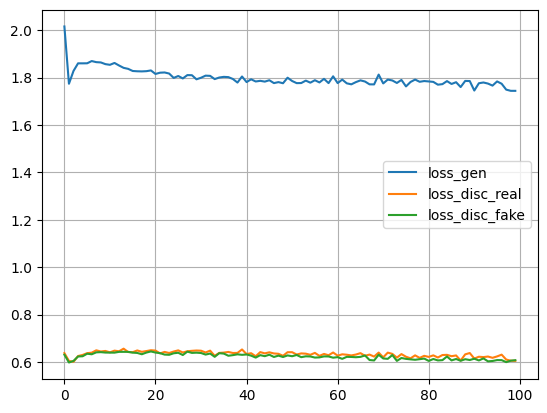

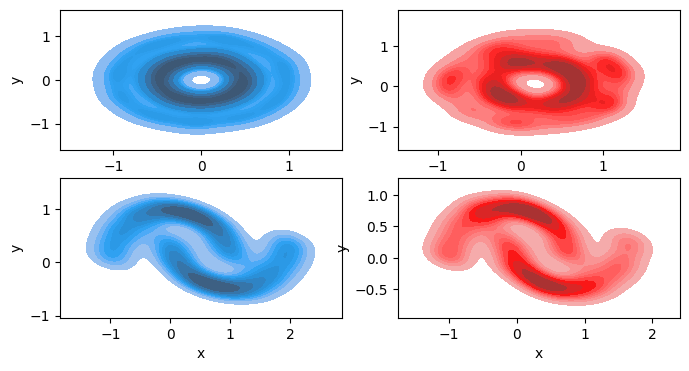

In [868]:
plt.figure()
for key, value in losses.items():
    plt.plot(range(len(value)), value, label=key)
plt.grid()
plt.legend()
plt.show()
visualize_CycleGAN(gan_x, gan_y, circles, moons)

# Adversarial Schrodinger bridge

In [13]:
!pip install numpy matplotlib scipy scikit-learn seaborn pandas tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.2 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 1.8 MB/s eta 0:00:00eta 0:00:01

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python -m pip install --upgrade pip


In [20]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.distributions.normal import Normal
from torch.distributions.kl import kl_divergence

import numpy as np
from scipy.stats import norm

from tqdm.notebook import tqdm

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

In [21]:
def get_simple_model(hiddens):
    assert len(hiddens) > 1
    modules = []
    for in_, out_ in zip(hiddens[:-2], hiddens[1:-1]):
        modules.extend([nn.Linear(in_, out_),nn.BatchNorm1d(out_), nn.ReLU()])
    modules.append(nn.Linear(hiddens[-2], hiddens[-1]))
    return nn.Sequential(*modules)

In [22]:
# Define of divergence's conjugate function
forward_kl_conjugate = lambda x: torch.exp(x - 1)
reverse_kl_conjugate = lambda x: -1 - torch.log(-x)
js_conjugate = lambda x: -torch.log(1 - torch.exp(x))

# Define of divergence's activation function
forward_kl_activation = lambda x: x
reverse_kl_activation = lambda x: -torch.exp(-x)
js_activation = lambda x: -torch.log(1 + torch.exp(-x))

# Divergences configuration
divergences = {'forward_kl': {'conj': forward_kl_conjugate, 'activ': forward_kl_activation},
               'reverse_kl': {'conj': reverse_kl_conjugate, 'activ': reverse_kl_activation},
               'js': {'conj': js_conjugate, 'activ': js_activation},
               }

In [47]:
class fGAN(nn.Module):
    def __init__(self, dim, divergence='js'):
        super().__init__()
        assert divergence in divergences.keys() 

        self.dim = dim
        self.activation = divergences[divergence]['activ']
        self.conjugate = divergences[divergence]['conj']
        self.gen = get_simple_model([dim, 32, 32, 32, dim])
        self.disc = get_simple_model([dim, 32, 32, 32, 1])        

    def sample(self, latent):
        with torch.no_grad():
            samples = self.gen(latent)
        return samples.detach().cpu().numpy()

    


############## TEST ##################
test_dim = 2
f_gan = fGAN(test_dim)
f_gan.sample(torch.rand((4, test_dim))).shape

(4, 2)

In [48]:
class Conditional(nn.Module):
    def __init__(self, in_dim, latent_dim):
        super().__init__()
        self.net = get_simple_model([in_dim, 32, 32, 32, 2 * latent_dim])

    def forward(self, x):
        return self.net(x).chunk(2, dim=1)
    
############## TEST ##################
test_in_dim = 2
test_latent_dim = 3
test_cond = Conditional(test_in_dim, test_latent_dim)
test_mu, test_log_std = test_cond(torch.rand((4, test_in_dim)))
test_mu.shape, test_log_std.shape

(torch.Size([4, 3]), torch.Size([4, 3]))

In [109]:
class AdversarialIPFPTrainer:
    def __init__(self, batch_size, gan_p, gan_q, conditional_p, conditional_q, marginal_q, marginal_p, lr_gen=1e-4, lr_disc=1e-4, lr_cond=1e-4):
        self.batch_size = batch_size
        self.dim  = gan_q.dim

        self.gan_p = gan_p
        self.gan_q = gan_q

        self.conditional_p = conditional_p
        self.conditional_q = conditional_q

        self.marginal_q = marginal_q
        self.marginal_p = marginal_p

        # self.device = conditional_q.device
        self.optim_gen = torch.optim.Adam([{'params': gan_p.gen.parameters()},
                                            {'params': gan_q.gen.parameters()}], lr=lr_gen)
        self.optim_disc = torch.optim.Adam([{'params': gan_p.disc.parameters()},
                                            {'params': gan_q.disc.parameters()}], lr=lr_disc)
        self.optim_cond = torch.optim.Adam([{'params': conditional_p.parameters()},
                                            {'params': conditional_q.parameters()}], lr=lr_cond)
        
    def train(self, iterations):
        # avg_loss_gen_b, avg_loss_disc_b = 0, 0
        # avg_loss_gen_f, avg_loss_disc_f = 0, 0

        losses = {
            'forward': {'gen': [], 'disc': []},
            'backward': {'gen': [], 'disc': []}
        }

        for iteration in range(iterations):
            # Sample true data
            x = self.marginal_q.sample([self.batch_size, self.dim])
            y = self.marginal_p.sample([self.batch_size, self.dim])

            # Make backward step
            loss_gen_b, loss_disc_b = self._backward_step(y, x)
            losses['backward']['gen'].append(loss_gen_b)
            losses['backward']['disc'].append(loss_disc_b)

            # Make forward step
            loss_gen_f, loss_disc_f = self._forward_step(x, y)
            losses['forward']['gen'].append(loss_gen_f)
            losses['forward']['disc'].append(loss_disc_f)
            
            if iteration % 50 == 0:
                print(f'Iteration: {iteration}; forward: gen: {loss_gen_f}, disc: {loss_disc_f}; backward: gen: {loss_gen_b}, disc: {loss_disc_b}')
        return losses
        
    def _backward_step(self, y, x):
        loss_gen = self._train_step_gen(y, self.gan_p, self.conditional_p, self.conditional_q, self.marginal_q)
        loss_disc = self._train_step_disc(self.gan_p, y, x)
        return loss_gen, loss_disc

    def _forward_step(self, x, y):
        loss_gen = self._train_step_gen(x, self.gan_q, self.conditional_q, self.conditional_p, self.marginal_p)
        loss_disc = self._train_step_disc(self.gan_q, x, y)
        return loss_gen, loss_disc
    
    def _train_step_gen(self, latent, gan, cond, cond_fixed, marginal):
        self.optim_gen.zero_grad()
        self.optim_cond.zero_grad()

        # Generate samples
        samples = gan.gen(latent)

        # Generator loss
        loss_gen = -gan.activation(gan.disc(samples)).mean()
        
        # Condition distribution loss
        mu, log_std = cond(samples)
        cond_dist = Normal(mu, torch.exp(log_std))
        with torch.no_grad():
            mu_fixed, log_std_fixed = cond_fixed(latent)
            cond_fixed_dist = Normal(mu_fixed, torch.exp(log_std_fixed))

        loss_conditional = kl_divergence(cond_dist, cond_fixed_dist).mean()

        # Cross entropy loss
        loss_ce = -marginal.log_prob(samples).mean()
        
        loss = loss_gen + loss_conditional + loss_ce
        loss.backward()
        self.optim_gen.step()
        self.optim_cond.step()
        
        return loss.detach().cpu().item()
    
    def _train_step_disc(self, gan, real, latent):
        self.optim_disc.zero_grad()

        # calc real loss
        pred_real = gan.disc(real)
        loss_real = gan.activation(pred_real).mean()

        # generated samples        
        with torch.no_grad():
            fake_samples = gan.gen(latent)
        pred_fake = gan.disc(fake_samples)
        loss_fake = gan.conjugate(gan.activation(pred_fake)).mean()

        # combine
        loss = loss_fake - loss_real
        loss.backward()
        self.optim_disc.step()
        return loss.detach().cpu().item()


# Experiments


## Unimodal experiments: 
1. $\pi_0(x) = \mathcal{N}(5, 1)$; $\pi_1(y) = \mathcal{N}(-2, 1)$
2. $\pi_0(x) = \mathcal{N}(0, 9)$; $\pi_1(y) = \mathcal{N}(20, 0.5^2)$

### Jense-Shannnon div

In [112]:
gan_p = fGAN(1)
gan_q = fGAN(1)
conditional_p = Conditional(1, 32)
conditional_q = Conditional(1, 32)
marginal_q = Normal(5, 1)
marginal_p = Normal(-2, 1)

trainer = AdversarialIPFPTrainer(32, gan_p, gan_q, conditional_p, conditional_q, marginal_q, marginal_p)
losses = trainer.train(5000)

Iteration: 0; forward: gen: 5.567203998565674, disc: 1.4206578731536865; backward: gen: 15.045125007629395, disc: 1.4004572629928589
Iteration: 50; forward: gen: 3.932807445526123, disc: 1.3531816005706787; backward: gen: 12.392641067504883, disc: 1.3878079652786255
Iteration: 100; forward: gen: 3.731691360473633, disc: 1.3399369716644287; backward: gen: 11.589470863342285, disc: 1.3654279708862305
Iteration: 150; forward: gen: 3.5221714973449707, disc: 1.3361897468566895; backward: gen: 11.00167179107666, disc: 1.3275864124298096
Iteration: 200; forward: gen: 3.3385627269744873, disc: 1.3052935600280762; backward: gen: 10.524876594543457, disc: 1.341975450515747
Iteration: 250; forward: gen: 3.178516387939453, disc: 1.2901792526245117; backward: gen: 10.024022102355957, disc: 1.3298617601394653
Iteration: 300; forward: gen: 2.9912872314453125, disc: 1.2639310359954834; backward: gen: 9.558289527893066, disc: 1.3126851320266724
Iteration: 350; forward: gen: 2.893632173538208, disc: 1.2

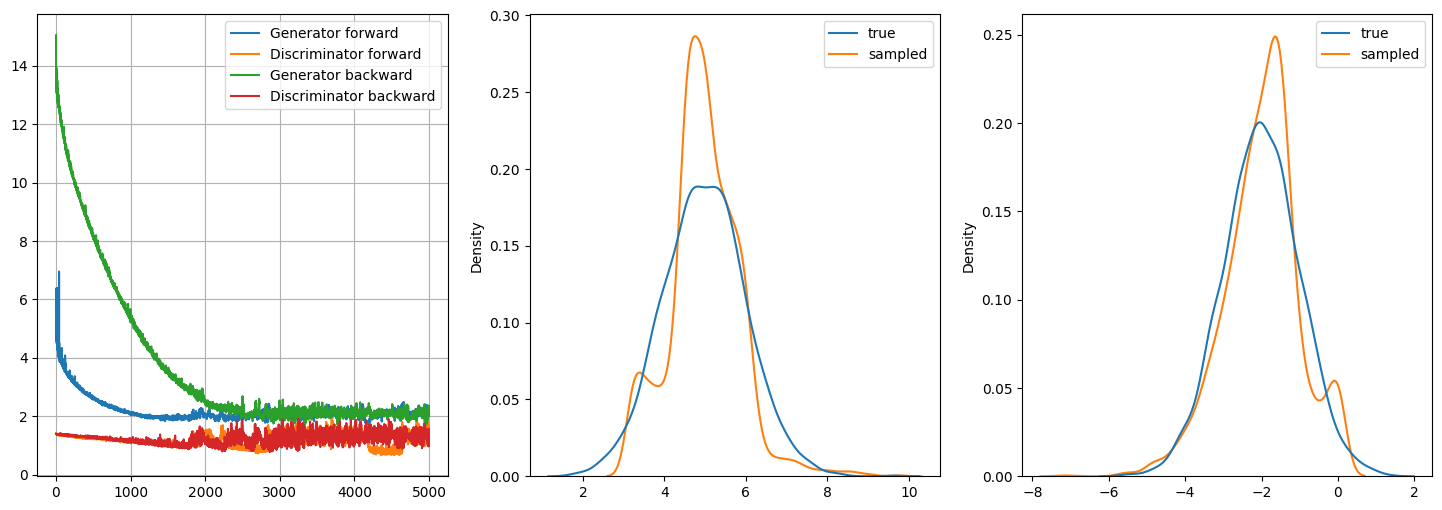

In [114]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
# Plot losses
axs[0].plot(losses['forward']['gen'], label='Generator forward')
axs[0].plot(losses['forward']['disc'], label='Discriminator forward')
axs[0].plot(losses['backward']['gen'], label='Generator backward')
axs[0].plot(losses['backward']['disc'], label='Discriminator backward')
axs[0].grid()
axs[0].legend()

# Plot samples 
n_samples = 2000
true_x = marginal_q.sample([n_samples, 1])
true_y = marginal_p.sample([n_samples, 1])

sampled_x = gan_p.sample(true_y)
df_x = {'true': true_x.squeeze(), 'sampled': sampled_x.squeeze()}
df_x = pd.DataFrame(df_x)
sns.kdeplot(df_x, ax=axs[1])

sampled_y = gan_q.sample(true_x)
df_y = {'true': true_y.squeeze(), 'sampled': sampled_y.squeeze()}
df_y = pd.DataFrame(df_y)
sns.kdeplot(df_y, ax=axs[2])

plt.show()

### KL-divergence

In [119]:
gan_p = fGAN(1, 'forward_kl')
gan_q = fGAN(1, 'forward_kl')
conditional_p = Conditional(1, 32)
conditional_q = Conditional(1, 32)
marginal_q = Normal(5, 1)
marginal_p = Normal(-2, 1)

trainer = AdversarialIPFPTrainer(32, gan_p, gan_q, conditional_p, conditional_q, marginal_q, marginal_p)
losses = trainer.train(4000)

Iteration: 0; forward: gen: 5.3302001953125, disc: 0.6851273775100708; backward: gen: 13.829456329345703, disc: 0.3780667781829834
Iteration: 50; forward: gen: 4.340636253356934, disc: 0.5908280611038208; backward: gen: 12.545273780822754, disc: 0.25739359855651855
Iteration: 100; forward: gen: 3.891781806945801, disc: 0.5418280959129333; backward: gen: 11.701598167419434, disc: 0.18822205066680908
Iteration: 150; forward: gen: 3.450451374053955, disc: 0.4111766815185547; backward: gen: 11.121711730957031, disc: 0.1235705316066742
Iteration: 200; forward: gen: 3.216791868209839, disc: 0.38433194160461426; backward: gen: 10.508024215698242, disc: 0.05706071853637695
Iteration: 250; forward: gen: 2.914079189300537, disc: 0.30258098244667053; backward: gen: 9.994415283203125, disc: 0.013625264167785645
Iteration: 300; forward: gen: 2.6816565990448, disc: 0.18500342965126038; backward: gen: 9.474943161010742, disc: -0.0038412809371948242
Iteration: 350; forward: gen: 2.562268018722534, dis

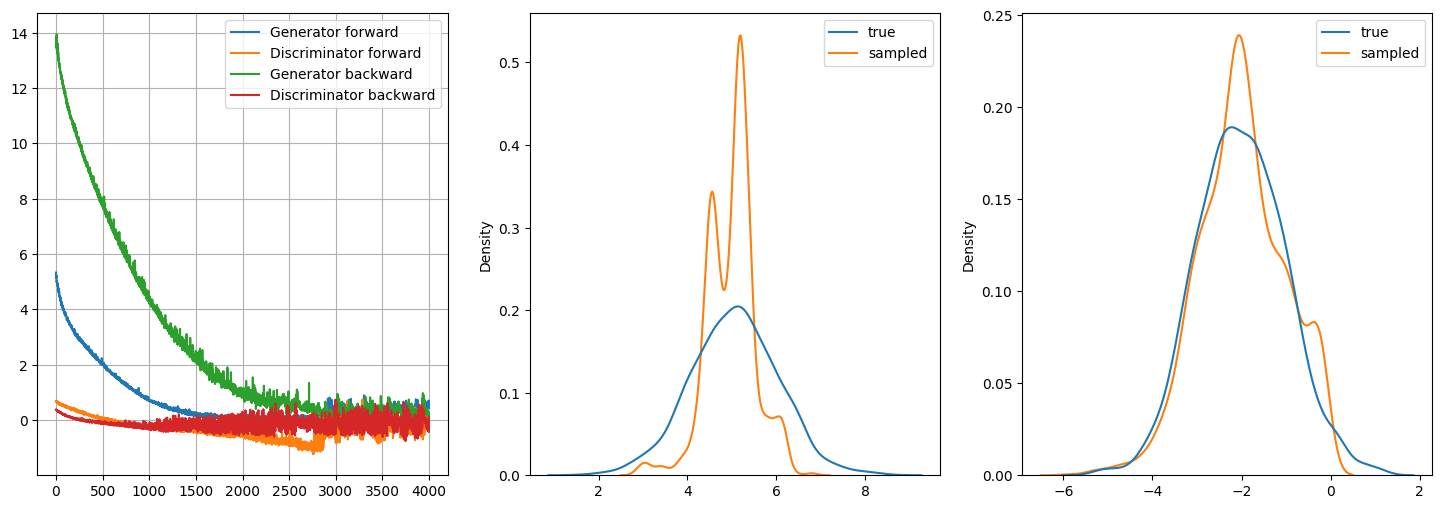

In [120]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
# Plot losses
axs[0].plot(losses['forward']['gen'], label='Generator forward')
axs[0].plot(losses['forward']['disc'], label='Discriminator forward')
axs[0].plot(losses['backward']['gen'], label='Generator backward')
axs[0].plot(losses['backward']['disc'], label='Discriminator backward')
axs[0].grid()
axs[0].legend()

# Plot samples 
n_samples = 2000
true_x = marginal_q.sample([n_samples, 1])
true_y = marginal_p.sample([n_samples, 1])

sampled_x = gan_p.sample(true_y)
df_x = {'true': true_x.squeeze(), 'sampled': sampled_x.squeeze()}
df_x = pd.DataFrame(df_x)
sns.kdeplot(df_x, ax=axs[1])

sampled_y = gan_q.sample(true_x)
df_y = {'true': true_y.squeeze(), 'sampled': sampled_y.squeeze()}
df_y = pd.DataFrame(df_y)
sns.kdeplot(df_y, ax=axs[2])

plt.show()


## Multimodal experiment
3. $\pi_0(x) = \mathcal{N}(0, 1)$; $\pi_1(y) = \frac12 \mathcal{N}(20, 0.5^2) + \frac12 \mathcal{N}(-20, 0.5^2)$ 